# VAE for COIL's duck

This notebook is the definition and the training of the VAE that predicts PI and the point clouds for the rotating duck dataset.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from time import time

import gudhi as gd
import gudhi.representations

import imageio

from tqdm import tqdm

## Load the data 

In [4]:
im_size = 128 * 128

In [1]:
images_duck = np.zeros((36, 128, 128))

NameError: name 'np' is not defined

In [20]:
for i in range(72):
    images_duck[i] = np.array(imageio.imread("COIL/obj1__" + str(i) + ".png"),
                              dtype=float)

IndexError: ignored

We normalize the picture

In [ ]:
images_duck /= 255.

We compute the PI for each duck image using a Cubical complexe.

In [ ]:
PI_size = 50
PI_duck = np.zeros((72, PI_size * PI_size))

images_duck_flat = np.zeros((72, 128 * 128))

PI = gd.representations.PersistenceImage(bandwidth=7e-2,
                                         weight=lambda x: x[1]**2,
                                         resolution=[50, 50],
                                         im_range=[0, 1, 0, 1])
for i in tqdm(range(72)):
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=images_duck[i])
    cubical_complex.compute_persistence()
    pi = PI.fit_transform(
        [cubical_complex.persistence_intervals_in_dimension(1)])
    PI_duck[i] = pi[0]
    images_duck_flat[i] = images_duck[i].flatten()

We create randomize the indexes of both the picture ant the PI arrays.

In [21]:
shuffler = np.random.permutation(images_duck.shape[0])
PI_train = PI_duck[shuffler]
images_train = images_duck_flat[shuffler]

We normalise the PIs.

In [22]:
PI_train /= np.max(PI_train)

## Create the VAE

This sections defines the VAE *via* multiple classes. 

In [23]:
class Sampling(tf.keras.layers.Layer):
    """Uses (mean_joint, var_joint) to sample z_joint, the latent vector encoding the output."""
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + z_var * epsilon


class Encoder_PI(tf.keras.layers.Layer):
    """Maps the PI of the input to a couple (z_mean, z_log_var)."""
    def __init__(self, latent_dim=2, name="encoder_PI", **kwargs):
        super(Encoder_PI, self).__init__(name=name, **kwargs)

        self.dense_100 = tf.keras.layers.Dense(100,
                                               activation='relu',
                                               name="dense_100_PI")
        self.dense_50 = tf.keras.layers.Dense(50, activation='relu')
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_var = tf.keras.layers.Dense(
            latent_dim)  #, activation='relu')

    def call(self, inputs):
        x = self.dense_100(inputs)
        y = self.dense_50(x)
        z_mean = self.dense_mean(y)
        z_var = self.dense_var(y)

        return z_mean, z_var


class Encoder_image(tf.keras.layers.Layer):
    """Maps the image of the input to a couple (z_mean, z_log_var)."""
    def __init__(self, latent_dim=2, name="encoder_image", **kwargs):
        super(Encoder_image, self).__init__(name=name, **kwargs)

        self.dense_100 = tf.keras.layers.Dense(100,
                                               activation='relu',
                                               name="dense_100_image")
        #self.dense_50 = tf.keras.layers.Dense(50, activation='relu')

        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_var = tf.keras.layers.Dense(
            latent_dim)  #, activation='relu')

    def call(self, inputs):
        x = self.dense_100(inputs)
        #x = self.dense_50(x)
        z_mean = self.dense_mean(x)
        z_var = self.dense_var(x)

        return z_mean, z_var


class Shared_Decoder(tf.keras.layers.Layer):
    """Converts z_joint, the encoded vector, back into a couple (z_joint_PI,z_joint_image)."""
    def __init__(self, latent_dim, name="shared_decoder", **kwargs):
        super(Shared_Decoder, self).__init__(name=name, **kwargs)
        self.dense_20 = tf.keras.layers.Dense(50, activation='relu')
        self.dense_output = tf.keras.layers.Dense(
            latent_dim + latent_dim)  #,activation='sigmoid')

    def call(self, inputs):
        x = self.dense_20(inputs)
        return self.dense_output(x)


class Decoder_PI(tf.keras.layers.Layer):
    """Converts z_joint_PI, the encoded vector, back into a readable PI."""
    def __init__(self, original_dim, name="decoder_PI", **kwargs):
        super(Decoder_PI, self).__init__(name=name, **kwargs)
        self.dense_100 = tf.keras.layers.Dense(100, activation='relu')

        self.dense_output = tf.keras.layers.Dense(original_dim)

    def call(self, inputs):
        x = self.dense_100(inputs)
        return self.dense_output(x)


class Decoder_image(tf.keras.layers.Layer):
    """Converts z_joint_im, the encoded vector, back into a readable image."""
    def __init__(self, original_dim, name="decoder_image", **kwargs):
        super(Decoder_image, self).__init__(name=name, **kwargs)
        self.dense_50 = tf.keras.layers.Dense(50, activation='relu')
        self.dense_100 = tf.keras.layers.Dense(100, activation='relu')
        #self.dense_200 = tf.keras.layers.Dense(200, activation='relu')
        self.dense_output = tf.keras.layers.Dense(
            original_dim)  #,activation='sigmoid')

    def call(self, inputs):
        x = self.dense_50(inputs)
        y = self.dense_100(x)
        #z = self.dense_200(y)

        return self.dense_output(y)


class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 original_dim_im,
                 original_dim_PI,
                 latent_dim=2,
                 name="autoencoder",
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        #self.original_dim = original_dim
        self.encoder_PI = Encoder_PI(latent_dim=latent_dim)
        self.decoder_PI = Decoder_PI(original_dim_PI)

        self.sampling = Sampling()

        self.shared_decoder = Shared_Decoder(latent_dim)

        self.encoder_image = Encoder_image(latent_dim=latent_dim)
        self.decoder_image = Decoder_image(original_dim=original_dim_im)

    def call(self, inputs):
        PI_inputs, image_inputs = inputs

        #First step, we encode the PI and image we have in input
        z_mean_PI, z_var_PI = self.encoder_PI(PI_inputs)
        z_mean_image, z_var_image = self.encoder_image(image_inputs)

        #We then compute (mean_joint, var_joint) by doing a product of gaussians
        mean_joint = (z_mean_PI / z_var_PI + z_mean_image / z_var_image) * (
            1 + 1 / z_var_PI + 1 / z_var_image)
        var_joint = (1 + 1 / z_var_PI + 1 / z_var_image)
        
        #We sample from the joint distribution 
        z_joint = self.sampling((mean_joint, var_joint))
          
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            tf.math.log(tf.square(var_joint)) - tf.square(mean_joint) -
            tf.square(var_joint) + 1, 0)

        self.add_loss(tf.reduce_sum(kl_loss))
        
        #We decode z_joint into z_PI, z_image
        z_PI, z_image = tf.split(self.shared_decoder(z_joint),
                                 num_or_size_splits=2,
                                 axis=1)

        #We decode z_PI, z_image into real PI and image
        reconstructed_PI = self.decoder_PI(z_PI)
        reconstructed_images = self.decoder_image(z_image)

        return reconstructed_PI, reconstructed_images

In [37]:
original_dim_PI = PI_size * PI_size

latent_dim = 2
vae = VariationalAutoEncoder(im_size, original_dim_PI, latent_dim)

optimizer = tf.keras.optimizers.Adamax(learning_rate=5e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

#We keep track of the losses
mse_loss_PI = []
mse_loss_images = []
kl_loss = []

#Number of epochs
epochs = 4000

# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch + 1, ))
    initial_time = time()
    
    # Iterate over the batches of the dataset.
    for i in range(images_train.shape[0]):
        with tf.GradientTape() as tape:
            reconstructed_PI, reconstructed_image = vae(
                (PI_train[i:i + 1], images_train[i:i + 1]))

            # Compute reconstruction loss
            # MSE loss for PI and for the images
            loss = 10000 * mse_loss_fn(PI_train[i], reconstructed_PI)
            loss += 10000 * mse_loss_fn(images_train[i], reconstructed_image)

            loss += tf.reduce_sum(vae.losses)  # Add KLD regularization loss
       
        # Compute the gradient   
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        #Keep track of the losses
        mse_loss_PI.append(mse_loss_fn(PI_train[i], reconstructed_PI))
        mse_loss_images.append(
            mse_loss_fn(images_train[i], reconstructed_image))
        kl_loss.append(vae.losses[0])

    print(
        "Epoch %d: MSE loss for PI = %.4e, MSE loss for Im = %.4e, KL loss = %.4e"
        % (epoch + 1, mse_loss_fn(PI_train[i], reconstructed_PI).numpy(),
           mse_loss_fn(images_train[i],
                       reconstructed_image).numpy(), vae.losses[0].numpy()))

    print("Time to compute epoch {} : {} sec".format(epoch + 1,
                                                     time() - initial_time))

Streaming output truncated to the last 5000 lines.
Epoch 2334: MSE loss for PI = 5.5887e-04, MSE loss for Im = 2.0992e-03, KL loss = 2.2825e+01
Time to compute epoch 2334 : 0.922501802444458 sec
Start of epoch 2335
Epoch 2335: MSE loss for PI = 4.8946e-04, MSE loss for Im = 1.5248e-03, KL loss = 2.9005e+01
Time to compute epoch 2335 : 0.9421026706695557 sec
Start of epoch 2336
Epoch 2336: MSE loss for PI = 1.6203e-03, MSE loss for Im = 2.5001e-03, KL loss = 2.6812e+01
Time to compute epoch 2336 : 0.9553928375244141 sec
Start of epoch 2337
Epoch 2337: MSE loss for PI = 8.0186e-04, MSE loss for Im = 4.4235e-03, KL loss = 2.7053e+01
Time to compute epoch 2337 : 0.9237921237945557 sec
Start of epoch 2338
Epoch 2338: MSE loss for PI = 1.4676e-03, MSE loss for Im = 3.4527e-03, KL loss = 2.8921e+01
Time to compute epoch 2338 : 0.9403691291809082 sec
Start of epoch 2339
Epoch 2339: MSE loss for PI = 7.9044e-04, MSE loss for Im = 1.5811e-03, KL loss = 2.3950e+01
Time to compute epoch 2339 : 0.9

We can plot the evolution of the errors

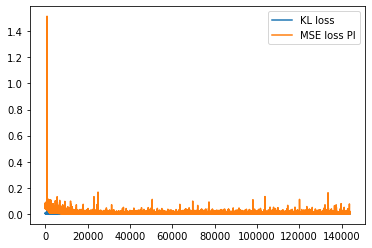

In [13]:
i = 100
#plt.plot(kl_loss[i:])
plt.plot(mse_loss_PI[i:])
plt.plot(mse_loss_images[i:])
plt.legend(["KL loss", "MSE loss PI", "MSE loss images"])
#plt.ylim(0,1)

### Quick look at the results

We can plot the results of a test dataset to see have our VAE did.

In [38]:
PI_pred, images_pred = vae((PI_train, images_train))

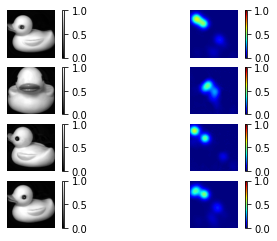

In [39]:
j = 0
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(np.reshape(images_pred[i + j], [128, 128]),
               vmin=0,
               vmax=1,
               cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(np.flip(np.reshape(PI_pred[i + j], [PI_size, PI_size]), 0),
               cmap='jet',
               vmin=0,
               vmax=1)
    plt.colorbar()
    plt.axis('off')
#plt.savefig("VAE_full_multiples_circles_predicted.pdf")

Here are the real images and the real PI.

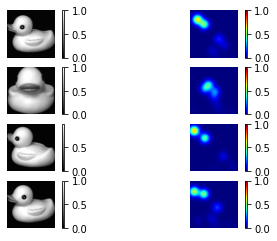

In [32]:
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.reshape(images_train[i + j], [128, 128]), cmap='gist_gray')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(4, 2, 2 * i + 2)
    #im = predictions[i, dim * N_points:]
    plt.imshow(np.flip(np.reshape(PI_train[i + j], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    plt.axis('off')

#plt.savefig("VAE_full_multiples_circles_true.pdf")

We can save our model

In [40]:
vae.save("/content/drive/MyDrive/VAE_full_duck_3d")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VAE_full_duck_3d/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VAE_full_duck_3d/assets
